# **Import Library dan Mount Google Drive**
Melakukan import seluruh library penting yang digunakan dalam proyek:
- pandas, numpy → manipulasi data.
- sklearn → preprocessing dan evaluasi model.
- matplotlib.pyplot → visualisasi hasil.
- tensorflow.keras → membuat model MLP dengan TensorFlow.
- torch, torch.nn, torch.utils.data → membuat dan melatih model MLP dengan PyTorch.
- tqdm → menampilkan progress bar saat training PyTorch.
- drive.mount() → untuk mengakses file dari Google Drive.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm  # Untuk progress bar
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load Dataset**
- Dataset dibaca dari path di Google Drive.
- Nama kolom diatur secara otomatis: kolom pertama adalah target, sisanya adalah feature_1, feature_2, dst.
- Dataset di-split menjadi data latih dan data uji dengan rasio 80:20.
- Preprocessing:
  - Fitur numerik di-scale menggunakan StandardScaler.
  - Fitur kategorikal di-encode menggunakan OneHotEncoder.
  - Output disatukan menggunakan ColumnTransformer, dan dikonversi ke bentuk array agar bisa diproses oleh TensorFlow dan PyTorch.

In [7]:
csv_path = '/content/drive/My Drive/Machine Learning/UAS/Task 1/RegresiUTSTelkom.csv'
df = pd.read_csv(csv_path, header=None)
df.columns = ["target"] + [f"feature_{i}" for i in range(1, df.shape[1])]

X = df.drop("target", axis=1)
y = df["target"]

# Deteksi fitur numerik dan kategorikal
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
], sparse_threshold=0)  # Pastikan hasilnya NumPy array, bukan sparse matrix

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# **TensorFlow MLP**
- Membangun arsitektur Multi-Layer Perceptron (MLP) dengan TensorFlow menggunakan Sequential.
- Struktur: Dense → BatchNormalization → Dropout, diulang 2x lalu ditutup dengan Dense output (1 neuron).
- Menggunakan Adam optimizer dan mean squared error (MSE) sebagai loss.
- Callback:
  - EarlyStopping: menghentikan training jika tidak ada peningkatan selama 10 epoch.
  - ReduceLROnPlateau: menurunkan learning rate saat training stagnan.

In [8]:
model_tf = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_proc.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1)
])

model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5)
]

history = model_tf.fit(X_train_proc, y_train, epochs=50, batch_size=32,
                       validation_split=0.2, callbacks=callbacks, verbose=0)

y_pred_tf = model_tf.predict(X_test_proc).flatten()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3221/3221 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


# **PyTorch MLP (Optimized)**
- Model MLP dengan struktur yang sama dibangun menggunakan PyTorch.
- Data dikonversi menjadi tensor dan dikirim ke GPU jika tersedia.
- Training dilakukan secara manual selama maksimal 30 epoch.
- Digunakan strategi early stopping manual:
  - Jika tidak ada perbaikan loss selama 5 epoch berturut-turut, training dihentikan.
- tqdm digunakan untuk menampilkan progress bar saat training berlangsung.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_t = torch.tensor(X_train_proc, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_t = torch.tensor(X_test_proc, dtype=torch.float32).to(device)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)

class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model_pt = MLPRegressor(X_train_proc.shape[1]).to(device)
optimizer = torch.optim.AdamW(model_pt.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = nn.MSELoss()

best_loss = float('inf')
patience = 5
counter = 0
max_epochs = 30

for epoch in range(max_epochs):
    model_pt.train()
    epoch_loss = 0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}"):
        optimizer.zero_grad()
        preds = model_pt(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    if avg_loss < best_loss - 1e-4:
        best_loss = avg_loss
        counter = 0
        best_model_state = model_pt.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

model_pt.load_state_dict(best_model_state)
model_pt.eval()
y_pred_pt = model_pt(X_test_t).detach().cpu().numpy().flatten()

Epoch 1/30: 100%|██████████| 12884/12884 [00:35<00:00, 365.08it/s]


Epoch 1, Loss: 662150.4203


Epoch 2/30: 100%|██████████| 12884/12884 [00:35<00:00, 367.27it/s]


Epoch 2, Loss: 34090.0001


Epoch 3/30: 100%|██████████| 12884/12884 [00:34<00:00, 375.82it/s]


Epoch 3, Loss: 30554.0106


Epoch 4/30: 100%|██████████| 12884/12884 [00:35<00:00, 366.61it/s]


Epoch 4, Loss: 28303.2184


Epoch 5/30: 100%|██████████| 12884/12884 [00:34<00:00, 376.42it/s]


Epoch 5, Loss: 26927.0190


Epoch 6/30: 100%|██████████| 12884/12884 [00:35<00:00, 358.23it/s]


Epoch 6, Loss: 26178.5462


Epoch 7/30: 100%|██████████| 12884/12884 [00:36<00:00, 354.19it/s]


Epoch 7, Loss: 25822.8435


Epoch 8/30: 100%|██████████| 12884/12884 [00:35<00:00, 361.21it/s]


Epoch 8, Loss: 25700.2437


Epoch 9/30: 100%|██████████| 12884/12884 [00:36<00:00, 349.21it/s]


Epoch 9, Loss: 25438.7176


Epoch 10/30: 100%|██████████| 12884/12884 [00:37<00:00, 339.74it/s]


Epoch 10, Loss: 25335.9843


Epoch 11/30: 100%|██████████| 12884/12884 [00:38<00:00, 331.24it/s]


Epoch 11, Loss: 25156.5935


Epoch 12/30: 100%|██████████| 12884/12884 [00:39<00:00, 323.55it/s]


Epoch 12, Loss: 25099.8001


Epoch 13/30: 100%|██████████| 12884/12884 [00:40<00:00, 319.52it/s]


Epoch 13, Loss: 24876.8103


Epoch 14/30: 100%|██████████| 12884/12884 [00:41<00:00, 312.63it/s]


Epoch 14, Loss: 24793.4758


Epoch 15/30: 100%|██████████| 12884/12884 [00:41<00:00, 310.08it/s]


Epoch 15, Loss: 24628.4934


Epoch 16/30: 100%|██████████| 12884/12884 [00:41<00:00, 308.07it/s]


Epoch 16, Loss: 24413.8554


Epoch 17/30: 100%|██████████| 12884/12884 [00:41<00:00, 310.29it/s]


Epoch 17, Loss: 24378.5653


Epoch 18/30: 100%|██████████| 12884/12884 [00:42<00:00, 303.78it/s]


Epoch 18, Loss: 24190.4005


Epoch 19/30: 100%|██████████| 12884/12884 [00:42<00:00, 304.44it/s]


Epoch 19, Loss: 24146.3781


Epoch 20/30: 100%|██████████| 12884/12884 [00:42<00:00, 304.06it/s]


Epoch 20, Loss: 23994.9958


Epoch 21/30: 100%|██████████| 12884/12884 [00:42<00:00, 302.81it/s]


Epoch 21, Loss: 23935.4089


Epoch 22/30: 100%|██████████| 12884/12884 [00:42<00:00, 303.30it/s]


Epoch 22, Loss: 23724.8391


Epoch 23/30: 100%|██████████| 12884/12884 [00:43<00:00, 299.49it/s]


Epoch 23, Loss: 23552.4788


Epoch 24/30: 100%|██████████| 12884/12884 [00:43<00:00, 298.90it/s]


Epoch 24, Loss: 23534.2839


Epoch 25/30: 100%|██████████| 12884/12884 [00:43<00:00, 299.20it/s]


Epoch 25, Loss: 23290.7085


Epoch 26/30: 100%|██████████| 12884/12884 [00:43<00:00, 299.41it/s]


Epoch 26, Loss: 23127.4715


Epoch 27/30: 100%|██████████| 12884/12884 [00:43<00:00, 298.43it/s]


Epoch 27, Loss: 23018.8737


Epoch 28/30: 100%|██████████| 12884/12884 [00:42<00:00, 299.93it/s]


Epoch 28, Loss: 22976.1727


Epoch 29/30: 100%|██████████| 12884/12884 [00:43<00:00, 297.33it/s]


Epoch 29, Loss: 22779.9878


Epoch 30/30: 100%|██████████| 12884/12884 [00:43<00:00, 296.51it/s]


Epoch 30, Loss: 22699.4879


# **Evaluasi Model**
- **MSE (Mean Squared Error)**  
  Mengukur rata-rata kuadrat dari selisih antara nilai aktual dan prediksi. Semakin kecil, semakin baik.

- **RMSE (Root Mean Squared Error)**  
  Akar dari MSE. Memberikan gambaran kesalahan dalam skala yang sama dengan target.

- **R² Score (Koefisien Determinasi)**  
  Menunjukkan seberapa besar variasi data target yang bisa dijelaskan oleh model.  
  - R² = 1.0 → Prediksi sempurna  
  - R² = 0.0 → Sama dengan rata-rata  
  - R² < 0.0 → Lebih buruk dari tebakan rata-rata


In [10]:
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

# Evaluasi
mse_tf, rmse_tf, r2_tf = evaluate(y_test, y_pred_tf)
mse_pt, rmse_pt, r2_pt = evaluate(y_test, y_pred_pt)

# Output tabel rapi
print("\n=== Evaluasi Model ===")
print(f"{'Model':<12} | {'MSE':>10} | {'RMSE':>10} | {'R²':>10}")
print("-" * 48)
print(f"{'TensorFlow':<12} | {mse_tf:10.4f} | {rmse_tf:10.4f} | {r2_tf:10.4f}")
print(f"{'PyTorch':<12} | {mse_pt:10.4f} | {rmse_pt:10.4f} | {r2_pt:10.4f}")



=== Evaluasi Model ===
Model        |        MSE |       RMSE |         R²
------------------------------------------------
TensorFlow   |   206.2731 |    14.3622 |    -0.7332
PyTorch      |   278.5428 |    16.6896 |    -1.3404


> - Model **TensorFlow memiliki performa lebih baik** dibanding PyTorch dalam eksperimen ini.
- Namun, **nilai R² negatif** menunjukkan bahwa model belum mampu memprediksi lebih baik daripada sekadar menebak rata-rata target.


# **Visualisasi Hasil**



> Grafik ini menunjukkan hubungan antara **nilai aktual (`Actual`)** dan **nilai hasil prediksi model (`Predicted`)** dari model TensorFlow:
>
> - **Sumbu X**: nilai aktual dari target pada data uji (`y_test`)
- **Sumbu Y**: hasil prediksi model terhadap data uji (`y_pred_tf`)



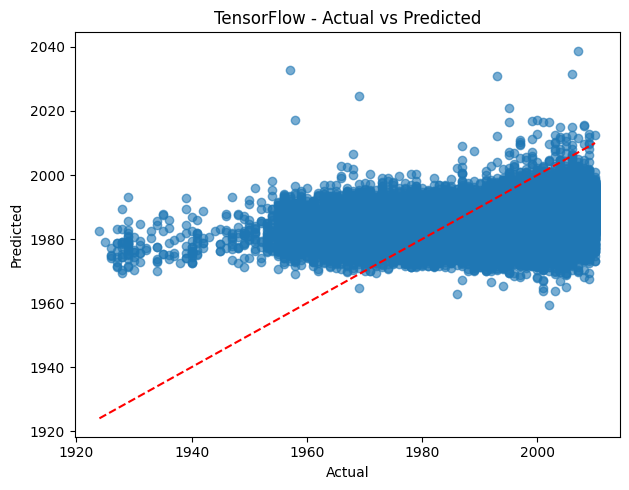

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_tf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("TensorFlow - Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.tight_layout()
plt.show()

> #### TensorFlow - Actual vs Predicted
- **Analisis**:
  - Banyak titik tidak berada di garis diagonal.
  - Model cenderung memprediksi nilai yang lebih sempit dari sebaran aktual.
  - Beberapa outlier muncul jauh di atas atau di bawah garis.
- **Kesimpulan**:  
  Model TensorFlow mampu menangkap pola umum, namun masih mengalami bias dan memiliki error cukup besar.


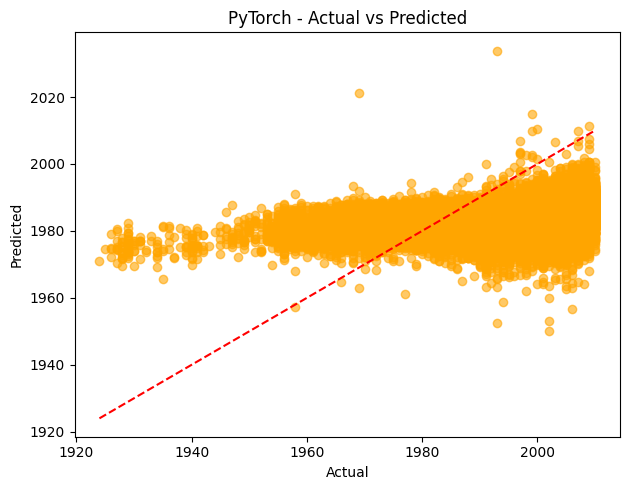

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_pt, alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("PyTorch - Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.tight_layout()
plt.show()

> #### PyTorch - Actual vs Predicted
- **Analisis**:
  - Pola sebaran titik mirip dengan model TensorFlow, tetapi dengan penyimpangan yang lebih besar.
  - Sebaran lebih rata, namun banyak prediksi yang meleset jauh dari nilai sebenarnya.
- **Kesimpulan**:  
  Model PyTorch menunjukkan performa prediksi yang lebih rendah dibanding TensorFlow, terlihat dari banyaknya titik yang jauh dari garis merah.


# **Kesimpulan Umum**
Model TensorFlow adalah yang terbaik berdasarkan semua metrik:
- RMSE dan MSE lebih rendah → prediksi lebih dekat ke nilai aktual.
- R² Score lebih tinggi (walaupun negatif) → model sedikit lebih baik dalam menjelaskan variasi data dibanding PyTorch.

> Namun, semua metrik menunjukkan bahwa model belum optimal, karena nilai R² masih negatif.
Ini berarti model masih perlu ditingkatkan (melalui tuning, preprocessing, atau mengganti algoritma).